<a href="https://colab.research.google.com/github/anunknownpleasure/Pricing-assets-with-deep-learning/blob/main/Asset_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Installing libraries


In [1]:
!pip install getFamaFrenchFactors

In [2]:
!pip install lxml

In [3]:
!pip install pandas_datareader

# 2. Data Import and preprocessing

## 2a. Importing Fama-French 5 factor data


In [4]:
import numpy as np
import pandas as pd
import getFamaFrenchFactors

print("Successfully imported getFamaFrenchFactors!")
print(dir(getFamaFrenchFactors))

Successfully imported getFamaFrenchFactors!
['BeautifulSoup', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', 'all_factor_links', 'all_factors_text', 'bold_tags', 'carhart4Factor', 'csv_links', 'factor_dict', 'famaFrench3Factor', 'famaFrench5Factor', 'ff3factor_dict', 'home_url', 'link', 'links_for_factor', 'momAndOthers_dict', 'momentumFactor', 'pd', 'relativedelta', 'requests', 'response', 'sib', 'soup', 'text', 'text_to_search', 'txt_links', 'url']


In [5]:
from getFamaFrenchFactors import famaFrench5Factor


# Get the factors
factors_df = famaFrench5Factor()

# Adjust from percentage
factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] = factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100



In [27]:
factors_df.head(20)

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.000039,-0.000048,-0.000081,0.0064,-0.0115,0.000027
1,1963-08-31,0.000508,-0.000080,0.000170,0.0040,-0.0038,0.000025
2,1963-09-30,-0.000157,-0.000043,0.000000,-0.0078,0.0015,0.000027
3,1963-10-31,0.000254,-0.000134,-0.000004,0.0279,-0.0225,0.000029
4,1963-11-30,-0.000086,-0.000085,0.000173,-0.0043,0.0227,0.000027
5,1963-12-31,0.000183,-0.000189,-0.000021,0.0012,-0.0025,0.000029
6,1964-01-31,0.000227,0.000010,0.000163,0.0021,0.0148,0.000030
7,1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026
8,1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031
9,1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029


We adjust the start date to -1-31-1964

In [28]:
FFdata = factors_df.iloc[6:]
FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])
FFdata = FFdata.set_index('date_ff_factors')

/tmp/ipython-input-4197135584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])


## 2b. Importing the macroeconomic data

In [23]:
import pandas_datareader.data as web

# --- 1. Define the 5 Long-History Macro Indicators (FRED Tickers) ---
long_macro_tickers = {
    'Term_Spread': 'T10YFFM',      # 10-Yr Yield minus Fed Funds Rate
    'Default_Spread': 'AAAFFM',     # Baa Corp Yield minus Aaa Corp Yield (Risk Aversion Proxy)
    'Ind_Production': 'INDPRO',     # Industrial Production Index
    'Unemployment': 'UNRATE',       # Civilian Unemployment Rate
    'Consumer_Sentiment': 'UMCSENT' # University of Michigan Consumer Sentiment
}

# --- 2. Define the Time Period
start_date = '1964-01-01'
end_date = '2025-08-31'

# --- 3. Fetch Data from FRED ---
try:
    macro_data = web.DataReader(
        list(long_macro_tickers.values()),
        'fred',
        start=start_date,
        end=end_date
    )
    macro_data.columns = list(long_macro_tickers.keys())

except Exception as e:
    print(f"Error fetching data from FRED: {e}")
    macro_data = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='M'))

# --- 4. Align Data to Monthly Frequency ---

# 4a. Forward-Fill any monthly gaps (common in macro data)
macro_data = macro_data.ffill()

# 4b. Ensure all data points are at the end of the month for clean alignment
macro_data = macro_data.resample('ME').last()


# --- 5. Display the result ---
print(f"Macro Data Imported and Aligned ({len(macro_data)} periods, starting {macro_data.index.min().strftime('%Y-%m')}):")
print(macro_data.head())
print("\n... and the tail:")
print(macro_data.tail())

# The resulting 'macro_data' DataFrame is ready for merging with Fama-French data.

Macro Data Imported and Aligned (740 periods, starting 1964-01):
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
1964-01-31         0.69            0.91         27.7409           5.6   
1964-02-29         0.67            0.88         27.9291           5.4   
1964-03-31         0.79            0.95         27.9291           5.4   
1964-04-30         0.76            0.93         28.3861           5.3   
1964-05-31         0.70            0.91         28.5474           5.1   

            Consumer_Sentiment  
DATE                            
1964-01-31                 NaN  
1964-02-29                99.5  
1964-03-31                99.5  
1964-04-30                99.5  
1964-05-31                98.5  

... and the tail:
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
2025-04-30        -0.05    

In [30]:
print(macro_data.shape, FFdata.shape)

(740, 5) (740, 6)


##2c. Importing the FF-portfolios

In [25]:
# --- 1. Define Time Period ---
# Must match the start date used for your FF factors and macro data (e.g., 1964-01-01)
start_date = '1964-01-01'
end_date = '2025-08-31'

# --- 2. Fetch the 25 Portfolios (Size x Book-to-Market) ---
# The data is downloaded as a dictionary object
ff_portfolio = web.DataReader(
    '25_Portfolios_5x5',
    'famafrench',
    start=start_date,
    end=end_date
)

df_returns_25 = ff_portfolio[0]

df_returns_25 = df_returns_25.replace([-99.99, -999], np.nan) # Missing values are indicated by -99.99 or -999
df_returns_25.dropna(inplace=True)

df_returns_25 = (df_returns_25/100)# Converting from percentage to fraction

# Convert PeriodIndex to DatetimeIndex at the end of the month
df_returns_25.index = df_returns_25.index.to_timestamp(how = 'end').date




/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'obje

## 2d. Combining all the data into a DataFrame

In [11]:
# Making the index into a datetime object
macro_data.index = pd.to_datetime(macro_data.index)


# Combine the dataframes using merge on the index

combined_data_FF_macro = pd.merge(FFdata, macro_data, left_index=True, right_index=True, how='inner') # Combining FF and Macro. Dropping first row because of a null value

combined_data = pd.merge(combined_data_FF_macro, df_returns_25, left_index=True, right_index=True, how='inner')

combined_data.dropna(inplace=True) # Dropping NaN entries

# Display the combined data
print("Combined Data:")
display(combined_data.head())
print("\n... and the tail:")
display(combined_data.tail())

Combined Data:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026,0.67,0.88,27.9291,5.4,...,0.025943,0.015619,0.028444,0.072047,0.046121,0.018271,0.005232,0.010194,0.039989,0.037567
1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031,0.79,0.95,27.9291,5.4,...,0.017750,0.029767,0.052497,0.071287,0.007247,0.011575,0.007635,0.036237,0.038382,0.001491
1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029,0.76,0.93,28.3861,5.3,...,-0.027045,0.003434,0.019784,-0.026384,-0.022805,0.002272,0.014745,0.008082,-0.009054,0.024147
1964-05-31,0.000141,-0.000062,0.000181,-0.0015,0.0013,0.000026,0.70,0.91,28.5474,5.1,...,0.011914,0.022992,0.013559,0.013281,0.040990,0.020599,0.003304,0.011776,0.042859,0.033968
1964-06-30,0.000127,0.000013,0.000068,-0.0033,0.0010,0.000030,0.67,0.91,28.6280,5.2,...,0.010927,0.014771,0.011035,0.024965,0.031119,0.009744,0.028644,0.004437,0.013682,0.024217



... and the tail:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
2025-04-30,-0.000084,-0.000186,-0.000340,-0.0285,-0.0267,0.000035,-0.05,1.12,103.6224,4.2,...,-0.008766,-0.012699,-0.020146,-0.039276,-0.072668,0.014106,-0.030129,-0.073867,-0.013472,-0.027941
2025-05-31,0.000606,-0.000072,-0.000288,0.0126,0.0251,0.000038,0.09,1.21,103.6570,4.2,...,0.062577,0.050222,0.035353,0.081175,0.065826,0.078077,0.061296,0.018407,0.026156,0.065684
2025-06-30,0.000486,-0.000002,-0.000160,-0.0319,0.0145,0.000034,0.05,1.13,104.2115,4.1,...,0.020351,0.043192,0.024175,0.073815,0.058024,0.055279,0.062451,0.047405,0.036424,0.070109
2025-07-31,0.000198,-0.000015,-0.000127,-0.0029,-0.0207,0.000034,0.06,1.12,103.8194,4.2,...,0.034206,0.021766,0.009013,-0.001069,-0.019303,0.032949,0.014068,0.012224,0.002333,-0.013744
2025-08-31,0.000185,0.000488,0.000441,-0.0069,0.0207,0.000038,-0.07,1.02,103.9203,4.3,...,0.036524,0.016164,0.023481,0.058848,0.071342,0.011610,0.011927,0.030567,0.054257,0.090799


In [12]:
combined_data.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Term_Spread',
       'Default_Spread', 'Ind_Production', 'Unemployment',
       'Consumer_Sentiment', 'SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4',
       'SMALL HiBM', 'ME2 BM1', 'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5',
       'ME3 BM1', 'ME3 BM2', 'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1',
       'ME4 BM2', 'ME4 BM3', 'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2',
       'ME5 BM3', 'ME5 BM4', 'BIG HiBM'],
      dtype='object')

In [13]:
FF_columns = combined_data.columns[:6]
macro_columns = combined_data.columns[6:11]
portfolio_columns = combined_data.columns[11:]

no_of_FF_features = len(FF_columns)
no_macro_features = len(macro_columns)
no_of_portfolios = len(portfolio_columns)




## 2e. Data Processing

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


processed_data = scaler.fit_transform(combined_data)
processed_data[:5]

processed_data.shape


(739, 36)

We create rolling windows for LSTM input

In [15]:
# Function to create rolling windows on a timeseries data

def rolling_window(data, lookback):
  x_rolling = []
  for i in range(len(data) - lookback):
    x_rolling.append(data[i: i + lookback])

  return np.array(x_rolling)

lookback = 12
ff_data = processed_data[:, :no_of_FF_features]
macro_data = processed_data[:, no_of_FF_features: no_of_FF_features + no_macro_features]
portfolio_data = processed_data[:, no_of_FF_features + no_macro_features:]

# Creating rolling window on macro data
X_macro_rolled = rolling_window(macro_data, lookback)

# Aligning the rolling data with FF factor and Portfolio data
X_ff_aligned = ff_data[lookback:]
Y_targets_aligned = portfolio_data[lookback:]




In [16]:
# Creating Dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset # Import Subset

class AssetPricingDataset(Dataset):

    def __init__(self, macro_data, ff_data, target_data):
        # 1. Convert all data to PyTorch tensors
        #    We use .float() for all data as they are continuous variables.
        self.X_macro = torch.tensor(macro_data).float()
        self.X_ff = torch.tensor(ff_data).float()
        self.Y_targets = torch.tensor(target_data).float()

    def __len__(self):
        return len(self.X_macro)

    def __getitem__(self, idx):
        return {
            'macro_X': self.X_macro[idx],    # Shape: [12, 5]
            'ff_X': self.X_ff[idx],          # Shape: [6]
            'target_Y': self.Y_targets[idx]  # Shape: [25]
        }

data = AssetPricingDataset(X_macro_rolled, X_ff_aligned, Y_targets_aligned)
no_of_samples = len(data)
train_size = int(len(data)*0.8)

# Use Subset to create train and test datasets
indices = list(range(no_of_samples))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)


BATCH_SIZE = 64

train_dataset = DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle = True, drop_last = True)
test_dataset = DataLoader(dataset = test_data, batch_size=BATCH_SIZE, shuffle = False, drop_last = False)

# **Model**

## Generator

In [17]:
class Generator(nn.Module):
  def __init__(self, macro_dim, hidden_dim, lstm_layers, sdf_dim):
    super().__init__()
    # Define the LSTM layer for processing macro data
    self.lstm = nn.LSTM(input_size= macro_dim,
                        hidden_size=hidden_dim,
                        num_layers=lstm_layers,
                        batch_first=True,
                        dropout=0.2 if lstm_layers > 1 else 0)

    self.fc1 = nn.Linear(hidden_dim, hidden_dim)
    self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
    self.activation = nn.LeakyReLU(0.2)     # Better activation
    self.dropout = nn.Dropout(0.2)          # Dropout for regularization
    self.fc2 = nn.Linear(hidden_dim, sdf_dim)

  def forward(self, macro_X, ff_X):
    _, (h_n, c_n) = self.lstm(macro_X)
    h_t = h_n[-1]

    x = self.fc1(h_t)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.dropout(x)
    f_t = self.fc2(x)

    return f_t, h_t



## Discriminator

In [18]:
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, hidden_dim, num_assets, hidden_layer):
        # hidden_dim is the size of h_t (e.g., 8)
        # num_assets is the size of the output portfolio weights g_t (25)
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(hidden_dim, hidden_layer)
        self.bn1 = nn.BatchNorm1d(hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, hidden_layer // 2)
        self.bn2 = nn.BatchNorm1d(hidden_layer // 2)
        self.fc3 = nn.Linear(hidden_layer // 2, num_assets)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, h_t):

        x = self.fc1(h_t)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        g_t = self.fc3(x)
        return g_t


In [19]:
# Loss function

def calculate_SDF(f_t, ff_X):
  ones = torch.ones(ff_X.shape[0], 1)
  ff_aug = torch.cat([ones, ff_X], dim=1)
  sdf_m = (f_t * ff_aug).sum(dim=1)

  return sdf_m

def discriminator_loss(f_t, g_t, ff_X, target_Y):
  SDF = calculate_SDF(f_t, ff_X)
  portfolio_returns = (g_t * target_Y).sum(dim=1)
  pricing_error_of_sample = SDF*portfolio_returns

  loss = -(pricing_error_of_sample.mean()**2)

  weight_penalty = 0.01 * (g_t ** 2).sum(dim=1).mean()

  return loss + weight_penalty

def generator_loss(f_t, g_t, ff_X, target_Y):
  SDF = calculate_SDF(f_t, ff_X)
  portfolio_returns = (g_t * target_Y).sum(dim=1)
  pricing_error_of_sample = SDF*portfolio_returns

  loss = pricing_error_of_sample.mean()**2
  sdf_penalty = 0.01 * (f_t ** 2).mean()

  return loss + sdf_penalty

In [20]:
# Training loop:
import torch.optim as optim
import matplotlib.pyplot as plt

macro_dim = 5
no_of_assets = 25
sdf_dim = 7

#Hyperparameters
hidden_dim = 8 # Generator hidden dimension
lstm_layers = 2
hidden_layer = 16 # Discriminator hidden dimension

generator = Generator(macro_dim, hidden_dim, lstm_layers, sdf_dim)
discriminator = Discriminator(hidden_dim, no_of_assets, hidden_layer)

D_learning_rate = 1e-4
G_learning_rate = 1e-4
D_optim = optim.Adam(discriminator.parameters(), lr = D_learning_rate)
G_optim = optim.Adam(generator.parameters(), lr = G_learning_rate)
epochs = 1000 # Increased epochs for plotting within 50th and 100th

# Lists to store losses for plotting per epoch
d_losses = []
g_losses = []


for epoch in range(epochs):
  D_loss = None # Initialize D_loss for the epoch
  G_loss = None # Initialize G_loss for the epoch
  for batch_idx, batch in enumerate(train_dataset):

    # Training the discriminator on data

    macro_X = batch['macro_X']
    ff_X = batch['ff_X']
    target_Y = batch['target_Y']

    D_optim.zero_grad()
    f_t, h_t = generator.forward(macro_X, ff_X)
    g_t = discriminator.forward(h_t.detach())

    D_loss = discriminator_loss(f_t.detach(), g_t, ff_X, target_Y)
    D_loss.backward()
    D_optim.step()

    # Training the generator

    G_optim.zero_grad()
    f_t, h_t = generator(macro_X, ff_X)
    g_t = discriminator(h_t) # D's weights are now fixed/frozen, but its output guides G

    # Assume loss_generator is defined to MINIMIZE the error (|Error|)
    G_loss= generator_loss(f_t, g_t, ff_X, target_Y)

    # F. Backward Pass & Update G
    G_loss.backward()
    G_optim.step()

  # Store losses after each epoch
  if D_loss is not None and G_loss is not None:
    d_losses.append(D_loss.item())
    g_losses.append(G_loss.item())
    if (epoch+1)%50 == 0: # Print every 50 epochs
      print(f'Epoch [{epoch+1}/{epochs}], Loss D: {D_loss.item():.6f}, Loss G: {G_loss.item():.6f}')
  #else:
    #print(f'Epoch [{epoch+1}/{epochs}]: No batches processed in this epoch.')

Epoch [50/1000], Loss D: 0.048597, Loss G: 0.545144
Epoch [100/1000], Loss D: -0.105148, Loss G: 2.763015
Epoch [150/1000], Loss D: 0.047292, Loss G: 0.460121
Epoch [200/1000], Loss D: 0.041997, Loss G: 2.592998
Epoch [250/1000], Loss D: 0.107692, Loss G: 0.012942
Epoch [300/1000], Loss D: -1.158236, Loss G: 10.317195
Epoch [350/1000], Loss D: -1.215583, Loss G: 0.001581
Epoch [400/1000], Loss D: 0.118469, Loss G: 0.976042
Epoch [450/1000], Loss D: 0.220961, Loss G: 0.264438
Epoch [500/1000], Loss D: 0.234834, Loss G: 0.001546
Epoch [550/1000], Loss D: 0.277611, Loss G: 0.875847
Epoch [600/1000], Loss D: -0.910160, Loss G: 1.523785
Epoch [650/1000], Loss D: -0.931449, Loss G: 8.463523
Epoch [700/1000], Loss D: -3.656436, Loss G: 30.477503
Epoch [750/1000], Loss D: -0.088061, Loss G: 10.815212
Epoch [800/1000], Loss D: -62.978035, Loss G: 3.324412
Epoch [850/1000], Loss D: -1.635329, Loss G: 32.340122
Epoch [900/1000], Loss D: 1.099253, Loss G: 0.002504
Epoch [950/1000], Loss D: -1.9454

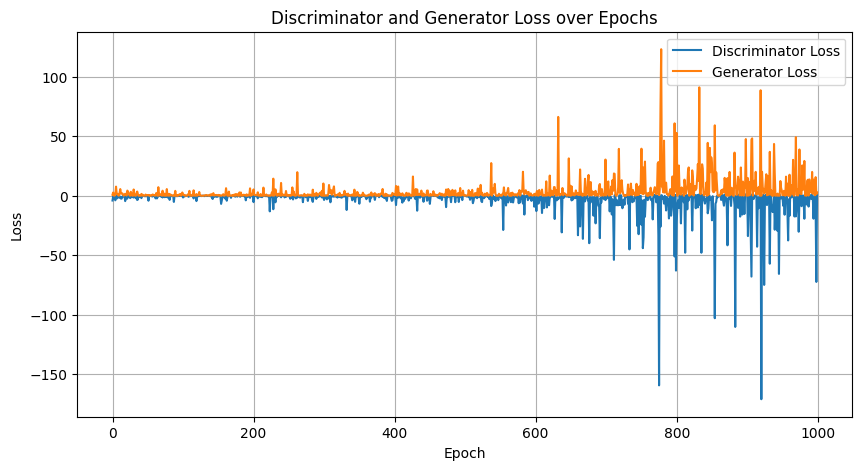

In [21]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), d_losses, label='Discriminator Loss')
plt.plot(range(epochs), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()